In [1]:
import sys
sys.path.append("../")

In [2]:
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior
from gpytorch.models.gplvm.latent_variable import *
from gpytorch.models.gplvm.bayesian_gplvm import BayesianGPLVM
from matplotlib import pyplot as plt
# from tqdm.notebook import trange
from tqdm import tqdm
from gpytorch.means import ZeroMean
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.utils.grid import ScaleToBounds
from datasets.cave_dataset import CAVEDataset
import numpy as np

/data/shubham/tv_opt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
class bGPLVM(BayesianGPLVM):
    def __init__(self, n, data_dim, latent_dim, n_inducing, pca=False):
        self.n = n
        self.batch_shape = torch.Size([data_dim])

        # Locations Z_{d} corresponding to u_{d}, they can be randomly initialized or
        # regularly placed with shape (D x n_inducing x latent_dim).
        self.inducing_inputs = torch.randn(data_dim, n_inducing, latent_dim)

        # Sparse Variational Formulation (inducing variables initialised as randn)
        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape)
        q_f = VariationalStrategy(self, self.inducing_inputs, q_u, learn_inducing_locations=True)

        # Define prior for X
        X_prior_mean = torch.zeros(n, latent_dim)  # shape: N x Q
        prior_x = NormalPrior(X_prior_mean, torch.ones_like(X_prior_mean))

        # params = torch.randn(n, latent_dim)
        params = torch.normal(0, 1, (n, latent_dim))
        X_init = torch.nn.Parameter(params)

        # LatentVariable (c)
        X = VariationalLatentVariable(n, data_dim, latent_dim, X_init, prior_x)

        # For (a) or (b) change to below:
        # X = PointLatentVariable(n, latent_dim, X_init)
        # X = MAPLatentVariable(n, latent_dim, X_init, prior_x)

        super().__init__(X, q_f)

        # Kernel (acting on latent dimensions)
        self.mean_module = ZeroMean(ard_num_dims=latent_dim)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))
        self.scale_to_bounds = ScaleToBounds(-1., 1.)

    def forward(self, X):
        X = self.scale_to_bounds(X)
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

    def _get_batch_idx(self, batch_size):
        valid_indices = np.arange(self.n)
        batch_indices = np.random.choice(valid_indices, size=batch_size, replace=False)
        return np.sort(batch_indices)

In [4]:
device = torch.device("cuda:0")
dataset = CAVEDataset("../datasets/data/CAVE", None, mode="train")
# lets create simple dataset for y
new_ds = torch.cat([data[0].reshape(31, -1) for data in dataset], -1).permute(1, 0) # num_samples, 31

In [45]:
smoke_test = False
N = new_ds.shape[0]
data_dim = 31 #31  # 12

latent_dim = data_dim
n_inducing = 512
pca = False

# Model
model = bGPLVM(N, data_dim, latent_dim, n_inducing, pca=pca).to(device)
# Likelihood
likelihood = GaussianLikelihood(batch_shape=model.batch_shape).to(device)

# Declaring the objective to be optimised along with optimiser
# (see models/latent_variable.py for how the additional loss terms are accounted for)
mll = VariationalELBO(likelihood, model, num_data=new_ds.shape[0])# total training points - 1000

In [6]:
model.eval()

bGPLVM(
  (variational_strategy): VariationalStrategy(
    (_variational_distribution): CholeskyVariationalDistribution()
  )
  (X): VariationalLatentVariable(
    (prior_x): NormalPrior()
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (scale_to_bounds): ScaleToBounds()
)

In [46]:
# visualize how we can correct R@z signals from our GP
loaded = torch.load("../artifacts/YGP.pt")
model.load_state_dict(loaded["model_state_dict"])
likelihood.load_state_dict(loaded['likelihood'])

<All keys matched successfully>

In [47]:
# generate some samples from the GP Prior distribution and plot
sample = model.sample_latent_variable()  # a full sample returns latent x across all N
sample_batch = sample[torch.Tensor(list(range(20))).to(torch.long)]
output_batch = likelihood(model(sample_batch))
# get some examples from Y spectral band dsi

In [11]:
def plot_samples(samples):
    x = range(31)
    for i, y in enumerate(samples.T):
        plt.plot(x, y.squeeze().detach().cpu().numpy())
    plt.xlabel("bands")
    plt.ylabel("scale")
    plt.show()

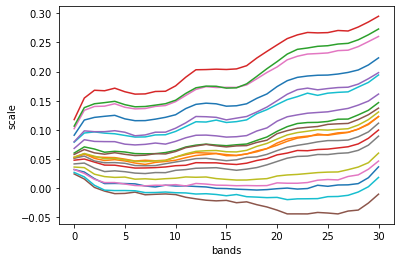

In [48]:
plot_samples(output_batch.loc)

In [49]:
samples = output_batch.loc - output_batch.loc.min(1).values[..., None] / output_batch.loc.max(1).values[..., None]

In [50]:
samples[samples < 0] = 0

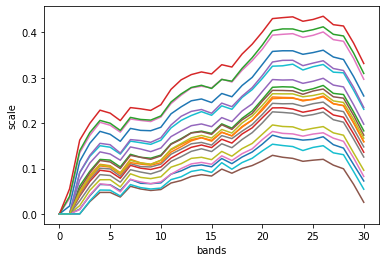

In [51]:
plot_samples(samples)

This looks like the desired sample distribution. lets take a few bands from Y and see do they actually look like this?

In [15]:
y_samples = new_ds[:20, :].T
y_samples = y_samples - y_samples.min(1).values[..., None] / y_samples.max(1).values[..., None]

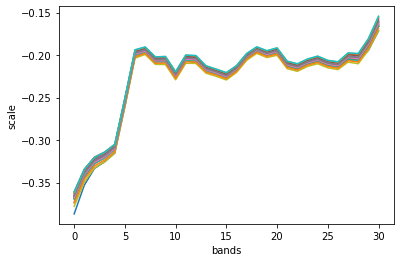

In [16]:
plot_samples(y_samples)

The most important part of the analysis is that give a sample from y what is the closest sample to y in the GP space. Lets look at that

In [52]:
output_y = likelihood(model(new_ds[:20, :].to(device)))

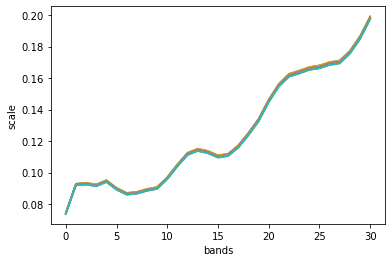

In [53]:
plot_samples(output_y.loc)

This is not giving the desired cluster representative samples. We need to investiage further on what did we just learn?

Lets add some variety to y and check the learning of our GPLVM.

In [54]:
batch_idxs = torch.randint(0, int(new_ds.shape[0]), (20, ))

In [55]:
y_samples = new_ds[batch_idxs].T

In [56]:
y_samples = y_samples - y_samples.min(1).values[..., None] / y_samples.max(1).values[..., None]

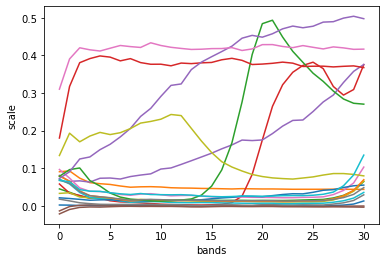

In [57]:
plot_samples(y_samples)

In [58]:
output_y = likelihood(model(y_samples.T.to(device)))

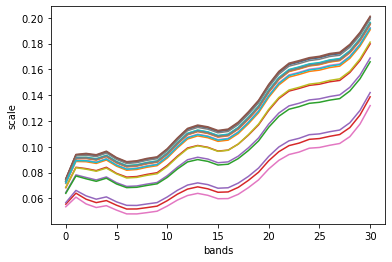

In [59]:
plot_samples(output_y.loc)

Sample complexity is not being captured by our model. Diagnosis -

1. Check epoch wise loss
If epoch wise loss would be decreasing then train for longer time else increase complexity of model.